# Определение токсичности комментариев

**Источник данных:** данные предоставлены заказчиком.

**Характер данных:** набор данных с разметкой о токсичности правок.

**Цель заказчика:** создание инструмента, который будет искать токсичные комментарии и отправлять их на модерацию.

**Задача исследования:** обучение модели классифицировать комментарии на позитивные и негативные.

**Условия обучения модели:** метрика F1 > 0.75.

---

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-окружения" data-toc-modified-id="Подготовка-окружения-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка окружения</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Общий-анализ-данных" data-toc-modified-id="Общий-анализ-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Общий анализ данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Очистка-и-лемматизация-текстов" data-toc-modified-id="Очистка-и-лемматизация-текстов-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Очистка и лемматизация текстов</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Разделение на выборки</a></span></li></ul></li></ul></li><li><span><a href="#Построение-модели" data-toc-modified-id="Построение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Построение модели</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#Decision-Tree-Classifier" data-toc-modified-id="Decision-Tree-Classifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Decision Tree Classifier</a></span></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Random Forest Classifier</a></span></li><li><span><a href="#Оценка-результатов" data-toc-modified-id="Оценка-результатов-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Оценка результатов</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Подготовка окружения

### Импорт библиотек

Установка необходимых библиотек:

In [1]:
%%capture --no-stderr
!pip install skorch nltk pymystem3 imblearn scikit-learn

Импорт необходимых библиотек:

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from typing import Tuple
import itertools
import collections
import torch
import re
import os
import warnings

# nlp
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

# search
import imblearn
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, \
                                    RandomizedSearchCV
from sklearn.utils import shuffle

from skorch.classifier import NeuralNetClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EpochScoring, EarlyStopping

# metrics
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, \
                            classification_report, confusion_matrix, \
                            precision_recall_curve, PrecisionRecallDisplay

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

Игнорирование предупреждений:

In [3]:
warnings.filterwarnings('ignore')

Задание случайных величин:

In [4]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

---

### Загрузка данных

Задание путей до сохранённых файлов:

In [5]:
corpus_file_path = 'corpus.csv'

Проверка существования файлов:

In [6]:
corpus_exists = os.path.exists(corpus_file_path) == True

Сохранение набора данных:

In [7]:
if corpus_exists:
    print('Updated saved file with corpus')
    data = pd.read_csv(corpus_file_path, index_col=0)
    
else:
    print('Updated initial file')
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

Updated saved file with corpus


Выведение на экран первых пяти строк набора данных:

In [8]:
data.head()

,text,toxic,corpus
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Выведение на экран размерности набора данных:

In [9]:
print('Размерность исходных данных:', data.shape)

Размерность исходных данных: (159292, 3)


---

### Общий анализ данных

Выведение на экран общей информации о наборе данных:

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
 2   corpus  159281 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


Выведение на экран количества пропущенных значений:

In [11]:
data.isna().sum()

text       0
toxic      0
corpus    11
dtype: int64

Выведение на экран количества дубликатов значений:

In [12]:
print('Дублирующихся значений:', data.duplicated().sum())

Дублирующихся значений: 0


Выведение на экран соотношения бинарных классов целевой переменной:

In [13]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Выведение на экран доли соотношения бинарных классов целевой переменной:

In [14]:
class_ratio = data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]

print('Соотношение классов:', round(class_ratio, 2))

Соотношение классов: 8.84


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Классы целевой переменной несбалансированны. 
    
</div>

---

### Предобработка данных

Задание функции определения тегов POS:

In [15]:
def get_wordnet_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN)

Задание функции, очищающей текст и приводящей слова к леммам:

In [16]:
def lemmatize(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    data = df.copy()
    col = df[col_name]
    
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    lemmatizer = WordNetLemmatizer()
    
    print('[1/3] Tokenizing...')
    updated_col = col.apply(lambda x: ' '.join(nltk.word_tokenize(re.sub(r'[^a-zA-Z]', ' ', x.lower()))))
    
    print('[2/3] Lemmatizing...')
    updated_col = updated_col.apply(lambda row: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) 
                                                 for word in row.split()])
        
    print('[3/3] Joining...')
    updated_col = updated_col.apply(lambda row: ' '.join(row))
    
    data['corpus'] = updated_col
    
    print('Saving...')
    data.to_csv('corpus.csv')
    
    print('Finished\n')
        
    return data

Задание функции построения крафика частоты слов:

In [17]:
def plot_most_common_words(corpus: pd.Series,
                           word_type: str = None,
                           n_common: int = 30) -> None:
    
    font_s = 12
    fig, ax = plt.subplots(figsize=(12,8))
    
    tokens = ' '.join(corpus).split()
    
    if word_type == 'bigrams':
        tokens = zip(tokens, tokens[1:])
    
    counts_no = collections.Counter(tokens)
    clean_reviews = pd.DataFrame(counts_no.most_common(n_common),
                                 columns=['words', 'count'])
    
    clean_reviews.sort_values(by='count').plot.barh(
        x='words', y='count', ax=ax, color='purple'
    )
    
    ax.set_title('Наиболее часто встречающиеся слова\n', fontsize=font_s+4)
    
    ax.set_xlabel('Частота', fontsize=font_s)
    ax.set_ylabel('Слова', fontsize=font_s)

    plt.grid()
    plt.show()

---

#### Очистка и лемматизация текстов

Помимо необходимости в лемматизации текстов необходимо учитывать, что в текстах могут встречаться редко используемые слова, а также отдельные буквы и другие короткие слова, которые не несут смысловой нагрузки и необходимо убрать.

Лемматизация текстовых значений с удалением редких слов:

In [18]:
%%time
if corpus_exists == False:
    data = lemmatize(data, 'text')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


Выведение на экран образца этапов обработки текста:

In [19]:
print('Initial text sample:\n', data['text'][0])
print('\nLemmatized same text:\n', data['corpus'][0])

Initial text sample:
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Lemmatized same text:
 explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now


Выведение на экран количества пропущенных значений:

In [20]:
data.isna().sum()

text       0
toxic      0
corpus    11
dtype: int64

Удаление пропущенных значений:

In [21]:
data = data.dropna().reset_index(drop=True)

Выведение на экран количества дубликатов значений:

In [22]:
print('Дублирующихся значений:', data.duplicated().sum())

Дублирующихся значений: 0


Построение графика наиболее часто встречающихся слов:

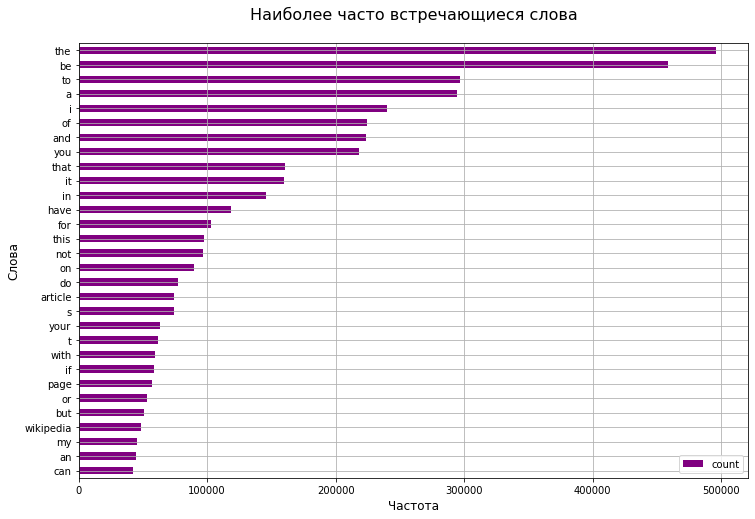

In [23]:
plot_most_common_words(data['corpus'])

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* В тексте много междометий и других служебных частей речи, которые будут убраны в процессе обработки TF-IDF.
    
</div>

---

#### Разделение на выборки

Задание признаков и целевого признака:

In [24]:
features = data['corpus']
target = data['toxic']

Разделение набора данных на тренировочную и тестовую выборки:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25)

Скачивание списка стоп-слов:

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Задание списка стоп-слов:

In [27]:
stop_words = list(set(stopwords.words('english')))

Выведение на экран размеров тренировочной и тестовой выборок:

In [28]:
print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

Train set: (119460,)
Test set: (39821,)


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Построение модели

Задание словаря с результатами подбора моделей:

In [29]:
results = {}

Задание функции построения матрицы неточностей:

In [30]:
def plot_c_matrix(y_valid: np.ndarray, y_pred: np.ndarray) -> None:
    font_s = 12
    plt.figure(figsize=(5,4))
    
    plt.title('Матрица неточностей\n', fontsize=font_s+4)

    c_matrix = confusion_matrix(y_valid, y_pred)    
    c_matrix = pd.DataFrame(c_matrix, 
                            index=['real not toxic', 'real toxic'],
                            columns=['pred not toxic', 'pred toxic'])
    
    sns.heatmap(c_matrix, 
                annot=True, 
                fmt='g',
                cmap='Blues',
                xticklabels=c_matrix.columns, 
                yticklabels=c_matrix.index, 
                annot_kws={'size': font_s+2})
    
    plt.xlabel('Preds', fontsize=font_s)
    plt.ylabel('Real', fontsize=font_s)

    plt.show()

Задание функции вычисления метрики ROC-AUC:

In [31]:
def get_auc_roc(model, X_valid: np.ndarray, y_valid: np.ndarray) -> Tuple[np.array, np.array, np.array]:
    y_pred = model.predict_proba(X_valid)
    probs_one_valid = y_pred[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, probs_one_valid)
    auc_roc = roc_auc_score(y_valid, probs_one_valid)

    return fpr, tpr, auc_roc

Задание функции построения графика обучения модели:

In [32]:
def plot_training_process(model) -> None:
    results = pd.DataFrame(model.cv_results_)
    results['params_str'] = results.params.apply(str)
    results.drop_duplicates(subset=('params_str', 'iter'), inplace=True)
    
    mean_scores = results.pivot(index='iter', columns='params_str',
                                values='mean_test_score')
    
    ax = mean_scores.plot(legend=False, alpha=.6)

    labels = [
        f'iter={i}\nn_samples={model.n_resources_[i]}\n'
        f'n_candidates={model.n_candidates_[i]}'
        for i in range(model.n_iterations_)
    ]

    ax.set_xticks(range(model.n_iterations_))
    ax.set_xticklabels(labels, rotation=45, multialignment='left')
    ax.set_title('Scores of candidates over iterations')
    ax.set_ylabel('mean test score', fontsize=15)
    ax.set_xlabel('iterations', fontsize=15)
    plt.tight_layout()
    plt.show()

Задание функции поиска лучшей модели:

In [33]:
def train_model(pipeline: dict,
                params: dict,
                X_train: np.ndarray,
                y_train: np.ndarray,
                name: str,
                cv: int = 3,
                scoring: str = 'f1',
                n_verbose: int = 0,
                save_to: dict = results) -> None:
    
    print('Searching...')
    
    if len(params) > 2:
        search = RandomizedSearchCV(
            pipeline, 
            params, 
            cv=cv, 
            n_jobs=-1, 
            scoring=scoring, 
            verbose=n_verbose
        )
    else:
        search = GridSearchCV(
            pipeline, 
            params, 
            cv=cv, 
            n_jobs=-1, 
            scoring=scoring, 
            verbose=n_verbose
        )
        
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_

    print(f'\nBest model params: {best_params}\n')
    print(f'Best F1-score: {round(best_score * 100, 2)} %\n')
    
    save_to[name] = {
        'model': best_model,
        'params': best_params,
        'score': best_score
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_valid)
    
    plot_c_matrix(y_valid, y_pred)
    
    save_to[name]['fpr_tpr_auc_roc'] = get_auc_roc(best_model, X_valid, y_valid)
    
    print('\nFinished\n')

Задание функции построения графика метрик:

In [34]:
def plot_bar(data: pd.DataFrame, 
             col_x: str,
             col_y: str,
             title: str,
             print_vals: bool = False,
             shift: float = 0.1) -> None:
    
    font_s = 12
    fig = plt.subplots(figsize=(16,5))

    plt.title(f'{title}\n', fontsize=font_s+4)
    
    labels = data[col_x]
    x = range(len(labels))
    y = data[col_y]
    
    plt.bar(x, y)
    
    if print_vals:
        for i, val in enumerate(y):
            plt.text(i-shift,  val-0.1, str(round(val * 100, 2)), fontsize=font_s, color='white')

    plt.xticks([i for i in x], labels, rotation=10)

    plt.xlabel(col_x, fontsize=font_s)
    plt.ylabel(col_y, fontsize=font_s)

    plt.grid()
    plt.plot()

Задание функции преобразования словаря в датафрейм:

In [35]:
def convert_to_dataframe(results: dict) -> pd.DataFrame:
    
    return pd.DataFrame(
        [val['score'] for val in results.values()], 
        index=results.keys(),
        columns=['score']
    )

---

* **Precision** (точность) — доля объектов, названных классификатором положительными и при этом действительно являющимися положительными.

>Чем меньше положительных, тем ниже точность. 

* **Recall** (полнота) — доля объектов положительного класса из всех объектов положительного класса, которую нашел алгоритм. 


* **F-мера** — среднее гармоническое precision и recall.

>Достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю.

* **AUC-ROC** — площадь под кривой ошибок. Помогает понять, насколько сильно модель отличается от случайной.

В качестве метрики, по которой будет производиться оценка моделей, будет взята **F-мера**.

Наиболее подходящими для решения поставленной перед исследованием задачи являются следующие модели:

* `Logistic Regression`
* `Decision Tree Classifier`
* `Random Forest Classifier`

Модели `KNeighborsClassifier`, `LightGBM Classifier` и `CatBoostClassifier` рассматриваться не будут, поскольку первая медленно работает на большом объёме данных, а для второй и третьей не хватает производительности для больших объёмов данных.

Кроме того, с учётом большого перевеса одного из целевых классов, необходимо обратиться к алгоритмам, которые будут их балансировать и отобрать те, что будут решать поставленную задачу лучше всего. Для этого существуют алгоритмы балансирования классов, предоставленные библиотекой `imblearn`:

* `ClusterCentroids`
* `CondensedNearestNeighbour`
* `EditedNearestNeighbours`
* `RepeatedEditedNearestNeighbours`
* `AllKNN`
* `InstanceHardnessThreshold`
* `NearMiss`
* `NeighbourhoodCleaningRule`
* `OneSidedSelection`
* `RandomUnderSampler`
* `TomekLinks`

Однако в силу низкой производительности большинства алгоритмов при большом объёме данных будет рассмотрен только алгоритм `RandomUnderSampler`.

----

Задание констант:

In [36]:
tfidf_vect = TfidfVectorizer(stop_words=stop_words)
undersampling = imblearn.under_sampling.RandomUnderSampler()

Задание параметров векторайзера:

In [37]:
params = {
    'tfidf__max_df': [0.25, 0.5, 0.75],
    'tfidf__min_df': range(2, 4),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)]
}

Задание параметров балансирования классов:

In [38]:
params_under = {
    'undersampling__sampling_strategy': ['majority', 'not majority', 'all', 'auto'],
    'undersampling__replacement': [True, False],
    'undersampling__random_state': [SEED, None]
}

---

### LogisticRegression

Задание констант:

In [39]:
model = LogisticRegression()

**Без балансирования классов**

Задание пайплайна:

In [40]:
pipeline = Pipeline([
    ('tfidf', tfidf_vect),
    ('model', model)
])

Задание параметров поиска:

In [41]:
params_lr = params.copy()
params_lr.update({
    'model__solver': ['lbfgs', 'saga'],
    'model__max_iter': range(100, 2000, 100),
    'model__class_weight': ['balanced', None],
    'model__random_state': [SEED, None],
    'model__C': range(1, 11, 1)
})

Поиск лучшей модели:

Searching...

Best model params: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 2, 'tfidf__max_df': 0.75, 'model__solver': 'lbfgs', 'model__random_state': None, 'model__max_iter': 1700, 'model__class_weight': 'balanced', 'model__C': 10}

Best F1-score: 77.14 %



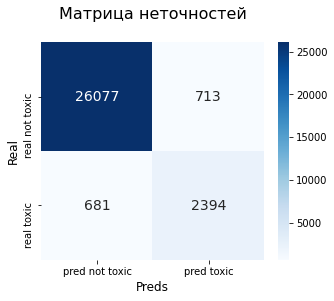


Finished

CPU times: user 16min, sys: 12min 30s, total: 28min 31s
Wall time: 28min 33s


In [42]:
%%time
train_model(pipeline, params_lr, X_train, y_train, 'log_regress', save_to=results)

**С балансированием классов**

Задание пайплайна:

In [43]:
pipeline = Pipeline([
    ('tfidf', tfidf_vect),
    ('undersampling', undersampling),
    ('model', model)
])

Задание параметров поиска:

In [44]:
params_lr = params_lr.copy()
params_lr.update(params_under)
del params_lr['model__class_weight']

Поиск лучшей модели:

Searching...

Best model params: {'undersampling__sampling_strategy': 'not majority', 'undersampling__replacement': False, 'undersampling__random_state': None, 'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 3, 'tfidf__max_df': 0.5, 'model__solver': 'lbfgs', 'model__random_state': 42, 'model__max_iter': 1600, 'model__C': 7}

Best F1-score: 75.32 %



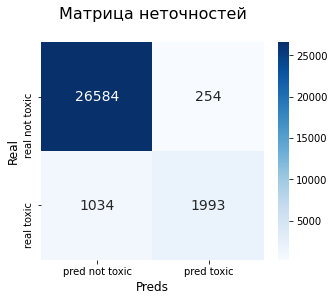


Finished

CPU times: user 9min 42s, sys: 8min 19s, total: 18min 2s
Wall time: 18min 3s


In [45]:
%%time
train_model(pipeline, params_lr, X_train, y_train, 'log_regress_under', save_to=results)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
Найденная модель продемонстрировала:
    
* Истинно-отрицательный уклон: предсказаны отрицательные ответы (комментарии НЕтоксичны) и это правда.
    
</div>

---

### Decision Tree Classifier

Задание констант:

In [46]:
model = DecisionTreeClassifier()

Задание параметров поиска:

In [47]:
params_dtc = params.copy()
params_dtc.update({
    'model__criterion': ['gini', 'entropy'],
    'model__splitter': ['best', 'random'],
    'model__class_weight': ['balanced', None],
    'model__max_depth': range(1, 20),
    'model__min_samples_leaf': range(1, 11),
    'model__min_samples_split': range(2, 11),
    'model__random_state': [SEED, None]
})

**Без балансирования классов**

Задание пайплайна:

In [48]:
pipeline = Pipeline([
    ('tfidf', tfidf_vect),
    ('model', model)
])

Поиск лучшей модели:

Searching...

Best model params: {'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 3, 'tfidf__max_df': 0.25, 'model__splitter': 'random', 'model__random_state': 42, 'model__min_samples_split': 4, 'model__min_samples_leaf': 6, 'model__max_depth': 15, 'model__criterion': 'gini', 'model__class_weight': None}

Best F1-score: 60.85 %



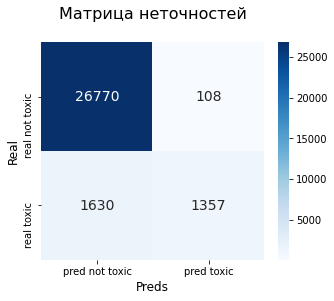


Finished

CPU times: user 7min 15s, sys: 11.2 s, total: 7min 27s
Wall time: 7min 27s


In [49]:
%%time
train_model(pipeline, params_dtc, X_train, y_train, 'dt_class')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
Найденная модель продемонстрировала:
    
* Истинно-отрицательный уклон: предсказаны отрицательные ответы (комментарии НЕтоксичны) и это правда.
    
</div>

**С балансированием классов**

Задание пайплайна:

In [50]:
pipeline = Pipeline([
    ('tfidf', tfidf_vect),
    ('undersampling', undersampling),
    ('model', model)
])

Задание параметров поиска:

In [51]:
params_dtc = params_dtc.copy()
params_dtc.update(params_under)
del params_dtc['model__class_weight']

Поиск лучшей модели:

Searching...

Best model params: {'undersampling__sampling_strategy': 'majority', 'undersampling__replacement': True, 'undersampling__random_state': None, 'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 3, 'tfidf__max_df': 0.5, 'model__splitter': 'best', 'model__random_state': None, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': 13, 'model__criterion': 'gini'}

Best F1-score: 58.58 %



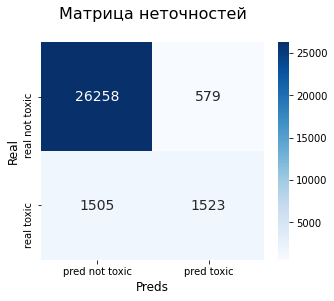


Finished

CPU times: user 5min 24s, sys: 6.37 s, total: 5min 30s
Wall time: 5min 31s


In [52]:
%%time
train_model(pipeline, params_dtc, X_train, y_train, 'dt_class_under')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
Найденная модель продемонстрировала:
    
* Истинно-отрицательный уклон: предсказаны отрицательные ответы (комментарии НЕтоксичны) и это правда.
    
</div>

---

### Random Forest Classifier

Задание констант:

In [53]:
model = RandomForestClassifier()

Задание параметров поиска:

In [54]:
params_rfc = params.copy()
params_rfc.update({
    'model__criterion': ['gini', 'entropy'],
    'model__n_estimators': range(100, 2000, 100),
    'model__class_weight': ['balanced', None],
    'model__max_depth': range(1, 20),
    'model__random_state': [SEED, None],
    'model__n_jobs': [-1]
})

**Без балансирования классов**

Задание пайплайна:

In [55]:
pipeline = Pipeline([
    ('tfidf', tfidf_vect),
    ('model', model)
])

Поиск лучшей модели:

Searching...

Best model params: {'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 3, 'tfidf__max_df': 0.5, 'model__random_state': 42, 'model__n_jobs': -1, 'model__n_estimators': 1000, 'model__max_depth': 13, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}

Best F1-score: 42.39 %



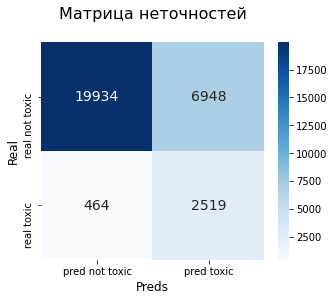


Finished

CPU times: user 23min 4s, sys: 10.9 s, total: 23min 15s
Wall time: 23min 16s


In [56]:
%%time
train_model(pipeline, params_rfc, X_train, y_train, 'rf_class')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
Найденная модель продемонстрировала:
    
* Истинно-отрицательный уклон: предсказаны отрицательные ответы (комментарии НЕтоксичны) и это правда.
    
</div>

**С балансированием классов**

Задание пайплайна:

In [57]:
pipeline = Pipeline([
    ('tfidf', tfidf_vect),
    ('undersampling', undersampling),
    ('model', model)
])

Задание параметров поиска:

In [58]:
params_rfc = params_rfc.copy()
params_rfc.update(params_under)
del params_rfc['model__class_weight']

Поиск лучшей модели:

Searching...

Best model params: {'undersampling__sampling_strategy': 'majority', 'undersampling__replacement': False, 'undersampling__random_state': None, 'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 2, 'tfidf__max_df': 0.75, 'model__random_state': 42, 'model__n_jobs': -1, 'model__n_estimators': 700, 'model__max_depth': 12, 'model__criterion': 'gini'}

Best F1-score: 39.47 %



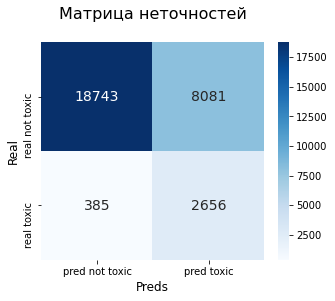


Finished

CPU times: user 16min 54s, sys: 5.22 s, total: 16min 59s
Wall time: 17min


In [59]:
%%time
train_model(pipeline, params_rfc, X_train, y_train, 'rf_class_under')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
Найденная модель продемонстрировала:
    
* Истинно-отрицательный уклон: предсказаны отрицательные ответы (комментарии НЕтоксичны) и это правда.
    
</div>

---

### Оценка результатов

Задание функции построения графика метрики AUC-ROC:

In [60]:
def plot_roc_curve(fpr_tpr_auc_roc: list, 
                   labels: list) -> None:
    
    font_s = 12
    plt.figure(figsize=(8,8))

    plt.title('ROC-кривая\n', fontsize=font_s+4)

    plt.plot([0, 1], [0, 1], linestyle='--', label='random_model')

    for i in range(len(fpr_tpr_auc_roc)):
        fpr, tpr, auc_roc = fpr_tpr_auc_roc[i]
        plt.plot(fpr, tpr, label=f'{labels[i]} - {round(auc_roc, 3)}')

    plt.legend(loc='lower right')

    plt.xlabel('False Positive Rate', fontsize=font_s)
    plt.ylabel('True Positive Rate', fontsize=font_s)

    plt.grid()
    plt.show()

Задание функции построения графика точности и полноты:

In [61]:
def plot_precision_recall(model,
                          X_test: np.ndarray,
                          y_true: np.ndarray) -> None:
    
    probabs_pred = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_true, probabs_pred)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()

    plt.grid()
    plt.show()

---

Преобразование результатов в датафрейм:

In [62]:
data_results = convert_to_dataframe(results).reset_index()

Построение графика значений метрик:

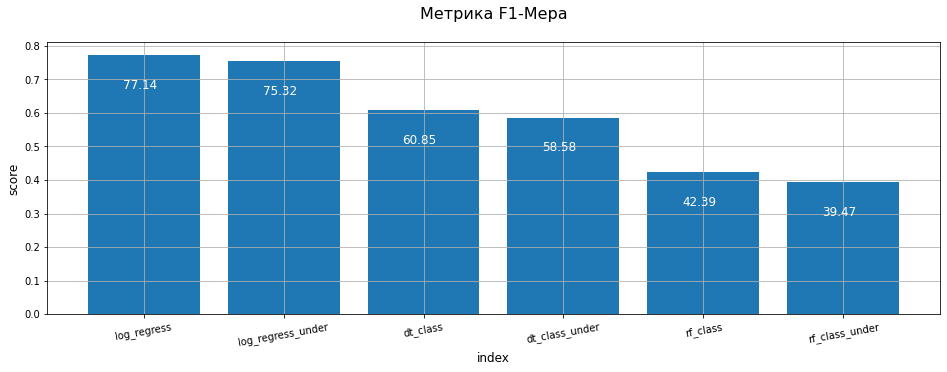

In [63]:
plot_bar(data_results, 'index', 'score', 'Метрика F1-Мера', print_vals=True, shift=0.15)

Сохранение данных для построения графика метрики AUC-ROC:

In [64]:
fpr_tpr_auc_roc_list = []

for key in list(results.keys()):    
    fpr_tpr_auc_roc_list.append(results[key]['fpr_tpr_auc_roc'])

Построение графика метрики AUC-ROC:

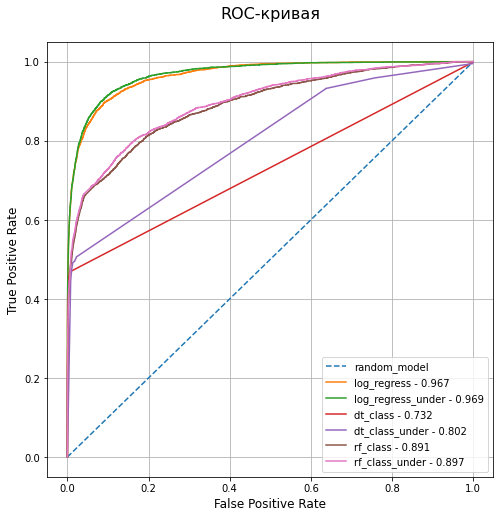

In [65]:
plot_roc_curve(fpr_tpr_auc_roc_list, list(results.keys()))

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Заданный порог метрики F1 в `0.75` превысила модель `LogisticRegression` как несбалансированных, так и на сбалансированных данных.
    
* Все модели, за исключением `Decision Tree Classifier` и `Random Forest Classifier`, продемонстрировали высокое отличие от произвольной модели на метрике AUC-ROC.
    
---

* С учётом скорости обработки данных для итогового тестирования будет отобрана модель `Logistic Regression`, обученная на сбалансированных данных.
    
</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Тестирование модели

Сохранение лучшей модели:

In [66]:
model = results['log_regress_under']['model']

Обучение модели:

In [67]:
%%time
model.fit(X_train, y_train)

CPU times: user 55.8 s, sys: 1min 7s, total: 2min 3s
Wall time: 2min 3s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=3, ngram_range=(1, 3),
                                 stop_words=['more', 'above', 'hadn', 'me', 'y',
                                             'does', 'been', 'should',
                                             "mightn't", 'aren', 'yourself',
                                             'down', 'm', 'doesn', 'only', 'at',
                                             'being', 'those', 'or', 'here',
                                             'an', 'll', "isn't", 'if',
                                             'between', 'herself', 'under',
                                             'of', "haven't", "didn't", ...])),
                ('undersampling',
                 RandomUnderSampler(sampling_strategy='not majority')),
                ('model',
                 LogisticRegression(C=7, max_iter=1600, random_state=42))])

Получение предсказаний:

In [68]:
y_pred = model.predict(X_test)

Выведение на экран значения метрики F1 на тестировочных данных:

In [69]:
print('F1 Test:', round(f1_score(y_test, y_pred) * 100, 2), '%')

F1 Test: 76.91 %


Выведение на экран метрик классификации модели:

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     35829
           1       0.89      0.68      0.77      3992

    accuracy                           0.96     39821
   macro avg       0.93      0.83      0.87     39821
weighted avg       0.96      0.96      0.96     39821



Построение матрицы неточностей:

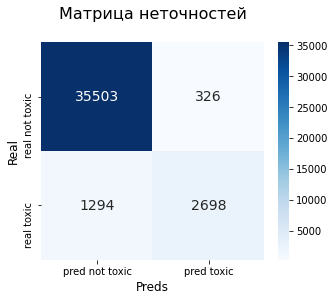

In [71]:
plot_c_matrix(y_test, y_pred)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
Найденная модель продемонстрировала на тестовых данных:
    
* Истинно-положительный уклон: предсказаны положительные ответы (комментарии токсичны) и это правда.
    
</div>

Построение графика полноты и точности:

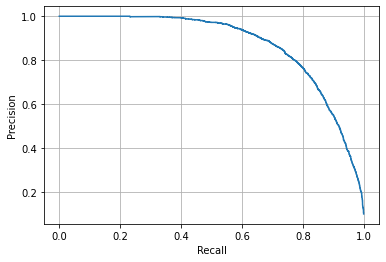

In [72]:
plot_precision_recall(model, X_test, y_test)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Модель показала неплохую предсказательную способность на тестовых данных, однако не достигла заданного порога. 
    
</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Общий вывод

В ходе проведённого исследования в ходе классификации комментариев на позитивные и негатичные с учётом таких факторов как производительность, скорость работы и значение метрики F1-меры наилучшим образом показала себя модель `Logistic Regression`.

Таким образом возможность создания инструмента, который будет искать токсичные комментарии и отправлять их на модерацию, на основании имеющихся данных была доказана, пусть модель и не смогла превысить заданного порога.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Проект-для-«Викишоп»" data-toc-modified-id="Проект-для-«Викишоп»" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>